Plot the contributions of different E fluxes in different model experiments (et - es - ei)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.stats
from pathos.threading import ThreadPool as Pool

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fol='/home/vanoorschot/work/fransje'

In [4]:
def global_mean_e_values(start_year,end_year,exp_name):
    f_mod = f'{fol}/htessel_output/{exp_name}'
    mod = xr.open_dataset(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    c_et = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','TVEG')
    c_es = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','ESOIL')
    c_ei = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','evatc')
    c_e = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','E')
    c_p = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','TP')
    c_q = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','RO')

    c_et.coord('latitude').guess_bounds()
    c_et.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(c_et)

    c_etm = c_et.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_esm = c_es.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_eim = c_ei.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_e = c_e.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_p = c_p.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_q = c_q.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)

    etm1 = xr.DataArray.from_iris(c_etm) * -1000
    esm1 = xr.DataArray.from_iris(c_esm) * -1000
    eim1 = xr.DataArray.from_iris(c_eim) * -1000
    em1= xr.DataArray.from_iris(c_e) * -1000
    pm1 = xr.DataArray.from_iris(c_p) * 1000
    qm1 = xr.DataArray.from_iris(c_q) * 1000
    
    em1_mean = np.round(em1.mean(dim='time').values,3)
    etm1_mean = np.round(etm1.mean(dim='time').values,3)
    esm1_mean = np.round(esm1.mean(dim='time').values,3)
    eim1_mean = np.round(eim1.mean(dim='time').values,3)
    pm1_mean = np.round(pm1.mean(dim='time').values,3)
    qm1_mean = np.round(qm1.mean(dim='time').values,3)
    
    etp = np.round((etm1_mean/em1_mean *100),3)
    esp = np.round((esm1_mean/em1_mean *100),3)
    eip = np.round((eim1_mean/em1_mean *100),3)

    return(etm1_mean,esm1_mean,eim1_mean,em1_mean,pm1_mean,qm1_mean,etp,esp,eip)

In [5]:
start_year,end_year=1999,2019
exp_names=['exp3','exp9','exp5','exp6']
df = pd.DataFrame(index=exp_names, columns=['etm','esm','eim','em','pm','qm','etp','esp','eip'])
for i in range(len(exp_names)):
    print (i)
    df.iloc[i,:] = global_mean_e_values(start_year,end_year,exp_names[i])

0
1
2
3


In [6]:
df

,etm,esm,eim,em,pm,qm,etp,esp,eip
exp3,0.517,0.503,0.273,1.312,2.238,0.863,39.405,38.338,20.808
exp9,0.725,0.248,0.32,1.319,2.238,0.858,54.966,18.802,24.261
exp5,0.527,0.497,0.274,1.318,2.238,0.858,39.985,37.709,20.789
exp6,0.498,0.534,0.262,1.313,2.238,0.863,37.928,40.67,19.954


In [7]:
def plot_e(exp_name,start_year,end_year):
    f_mod = f'{fol}/htessel_output/{exp_name}'
    mod = xr.open_dataset(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    et = mod.TVEG * -1000
    es = mod.ESOIL * -1000
    p = mod.TP * 1000
    q = mod.RO * 1000
    e = mod.E * -1000
    ei = mod.evatc * -1000
    
    # add cubes for mean value calculation

    etm = et.mean(dim='time')
    esm = es.mean(dim='time')
    eim = ei.mean(dim='time')
    em = e.mean(dim='time')
    pm = p.mean(dim='time')
    qm = q.mean(dim='time')
    
    etf = etm/em
    esf = esm/em
    eif = eim/em

    cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(0,3,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = etm.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'et (mm/day)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean et {exp_name}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_et_{exp_name}.jpg',bbox_inches='tight')

    cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(0,3,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = esm.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'es (mm/day)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean es {exp_name}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_es_{exp_name}.jpg',bbox_inches='tight')

    cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(0,3,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = eim.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'ei (mm/day)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean ei {exp_name}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_ei_{exp_name}.jpg',bbox_inches='tight')
    
    cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(0,5,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = em.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'e (mm/day)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean e total {exp_name}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_etotal_{exp_name}.jpg',bbox_inches='tight')
    
    cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(0,1,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = etf.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'et/e (-)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean et/mean etotal {exp_name}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_et_etotal_{exp_name}.jpg',bbox_inches='tight')
    
    cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(0,1,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = esf.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'es/e (-)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean es/mean etotal {exp_name}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_es_etotal_{exp_name}.jpg',bbox_inches='tight')
    
    cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(0,1,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = eif.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'ei/e (-)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean ei/mean etotal {exp_name}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_ei_etotal_{exp_name}.jpg',bbox_inches='tight')

In [8]:
def plot_ediff(exp_name1, exp_name2,start_year,end_year):
    f_mod = f'{fol}/htessel_output/{exp_name1}'
    mod = xr.open_dataset(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    et = mod.TVEG * -1000
    es = mod.ESOIL * -1000
    p = mod.TP * 1000
    q = mod.RO * 1000
    e = mod.E * -1000
    ei = mod.evatc * -1000
    
    # add cubes for mean value calculation
    etm1 = et.mean(dim='time')
    esm1 = es.mean(dim='time')
    eim1 = ei.mean(dim='time')
    em1 = e.mean(dim='time')
    pm1 = p.mean(dim='time')
    qm1 = q.mean(dim='time')
    
    etf1 = etm1/em1
    esf1 = esm1/em1
    eif1 = eim1/em1
    
    f_mod = f'{fol}/htessel_output/{exp_name2}'
    mod = xr.open_dataset(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    et = mod.TVEG * -1000
    es = mod.ESOIL * -1000
    p = mod.TP * 1000
    q = mod.RO * 1000
    e = mod.E * -1000
    ei = mod.evatc * -1000
    
    # add cubes for mean value calculation
    etm2 = et.mean(dim='time')
    esm2 = es.mean(dim='time')
    eim2 = ei.mean(dim='time')
    em2 = e.mean(dim='time')
    pm2 = p.mean(dim='time')
    qm2 = q.mean(dim='time')
    
    etf2 = etm2/em2
    esf2 = esm2/em2
    eif2 = eim2/em2

    etm = etm2 - etm1
    esm = esm2 - esm1
    eim = eim2 - eim1
    em = em2 - em1
    etf = etf2 - etf1
    esf = esf2 - esf1
    eif = eif2 - eif1

    cm = plt.cm.get_cmap('RdYlGn',20)
    lvls = np.linspace(-1,1,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = etm.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'et (mm/day)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean et diff {exp_name2} - {exp_name1}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_etdiff_{exp_name2}_{exp_name1}.jpg',bbox_inches='tight')

    # cm = plt.cm.get_cmap('viridis_r',20)
    # lvls = np.linspace(0,3,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = esm.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'es (mm/day)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean es diff {exp_name2} - {exp_name1}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_esdiff_{exp_name2}_{exp_name1}.jpg',bbox_inches='tight')

    # cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(-0.2,0.2,11)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = eim.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'ei (mm/day)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean ei diff {exp_name2} - {exp_name1}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_eidiff_{exp_name2}_{exp_name1}.jpg',bbox_inches='tight')
    
    lvls = np.linspace(-0.2,0.2,11)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = em.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'etotal (mm/day)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean etotal diff {exp_name2} - {exp_name1}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_etotaldiff_{exp_name2}_{exp_name1}.jpg',bbox_inches='tight')
    
    
    cm = plt.cm.get_cmap('RdYlGn',20)
    lvls = np.linspace(-0.5,0.5,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = etf.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'et/e (-)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean et/mean etotal  diff {exp_name2} - {exp_name1}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_et_etotal_diff_{exp_name2}_{exp_name1}.jpg',bbox_inches='tight')
    
    # cm = plt.cm.get_cmap('viridis_r',20)
    # lvls = np.linspace(0,1,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = esf.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'es/e (-)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean es/mean etotal  diff {exp_name2} - {exp_name1}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_es_etotal_diff_{exp_name2}_{exp_name1}.jpg',bbox_inches='tight')
    
    # cm = plt.cm.get_cmap('viridis_r',20)
    lvls = np.linspace(-0.1,0.1,21)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cf = eif.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'ei/e (-)', pad=0.05, ticks=lvls,extend='both')
    ax.set_title(f'mean ei/mean etotal  diff {exp_name2} - {exp_name1}')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/map_ei_etotal_diff_{exp_name2}_{exp_name1}.jpg',bbox_inches='tight')

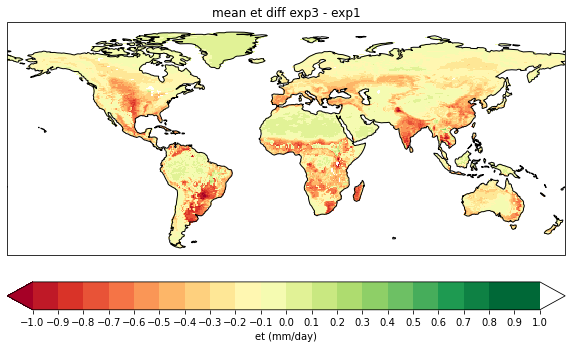

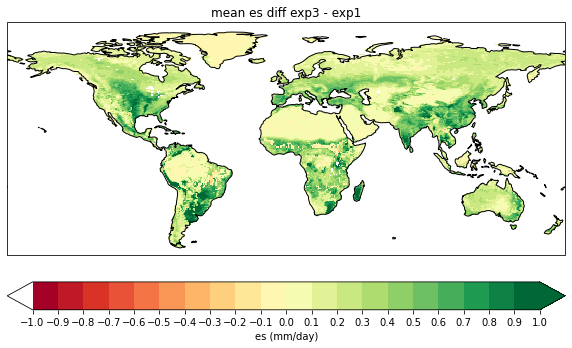

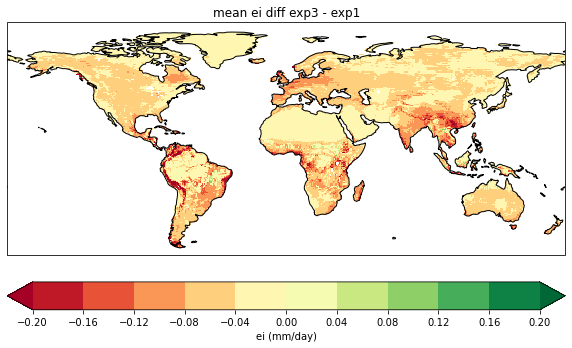

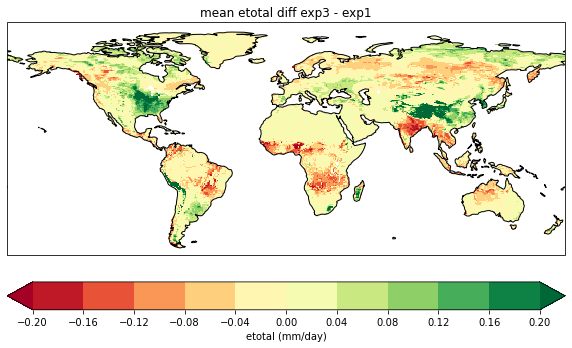

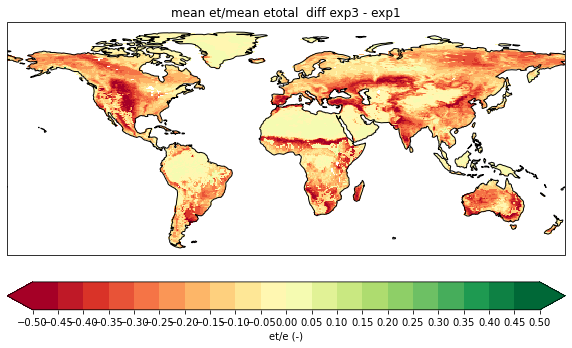

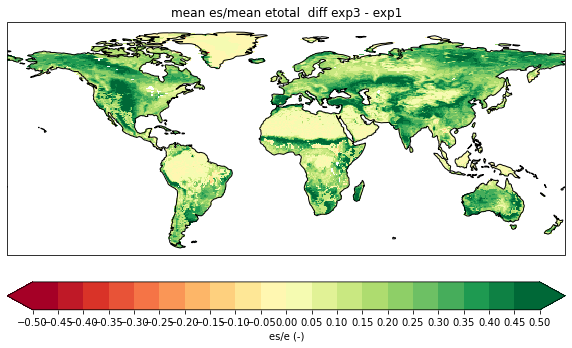

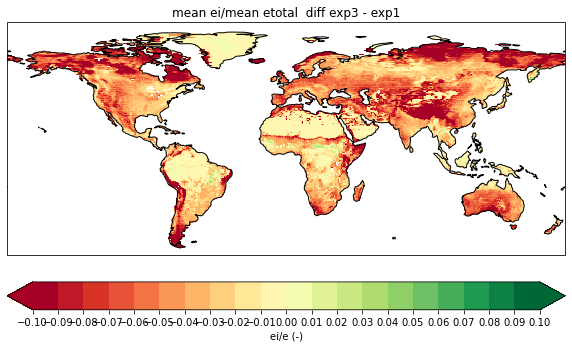

In [9]:
start_year='1999'
end_year='2018'

exp_name1='exp1'
exp_name2='exp3'

plot_ediff(exp_name1, exp_name2,start_year,end_year)

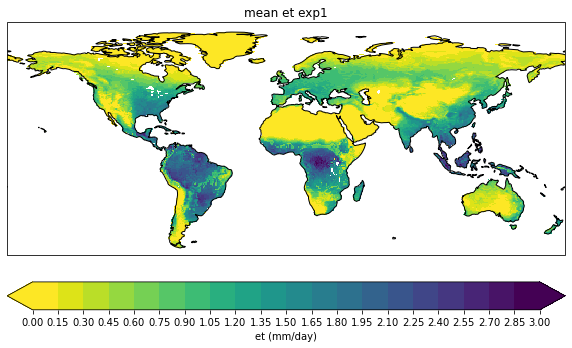

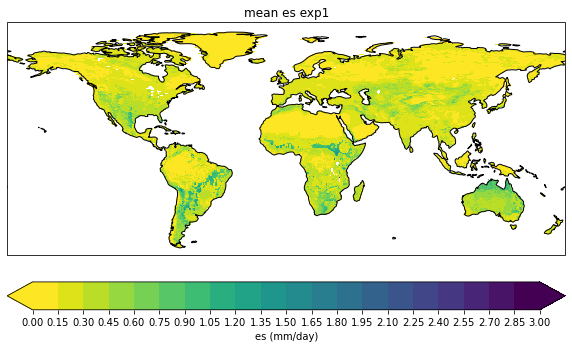

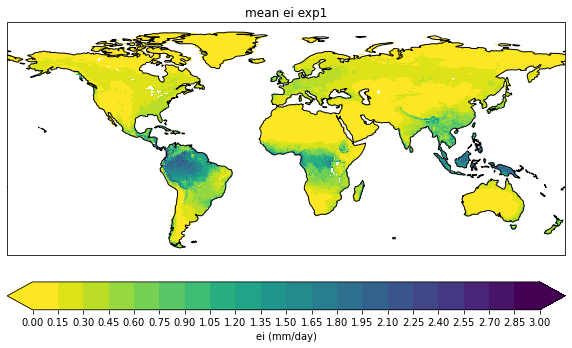

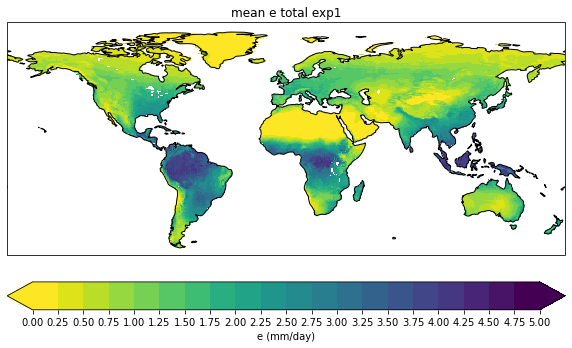

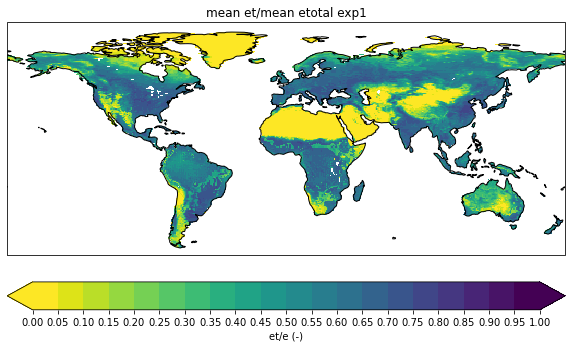

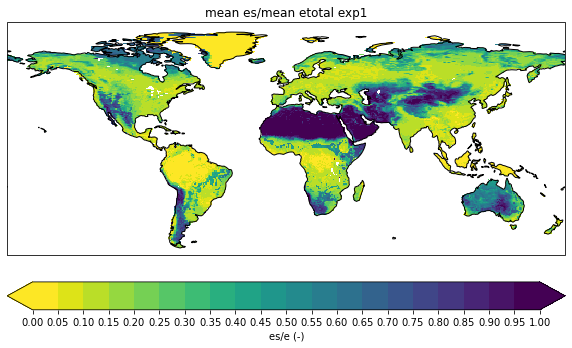

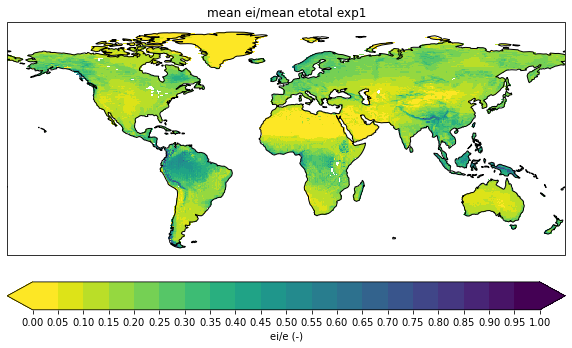

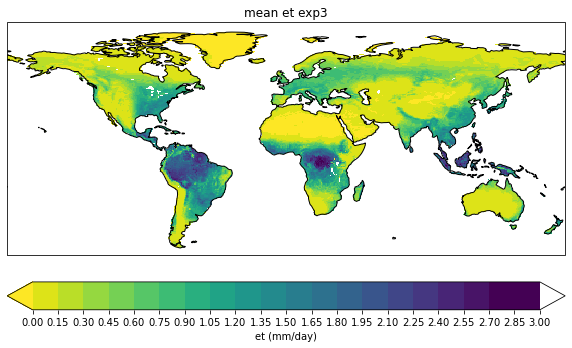

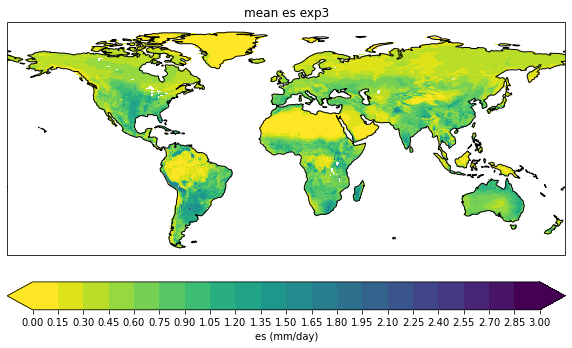

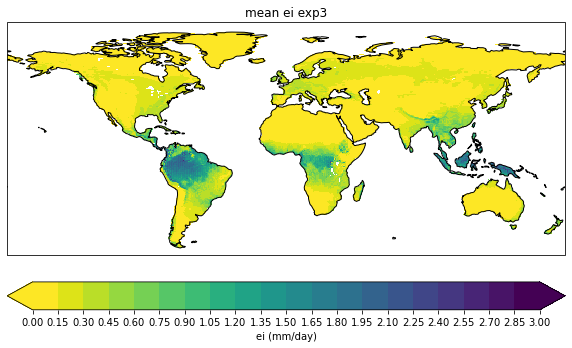

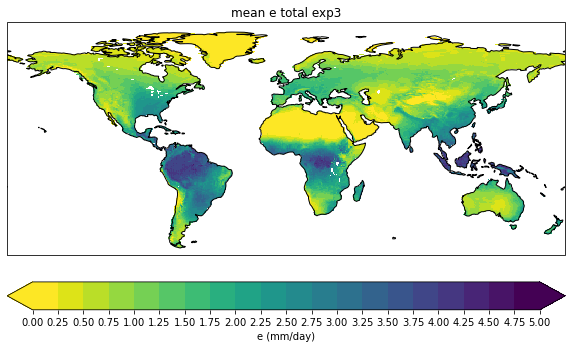

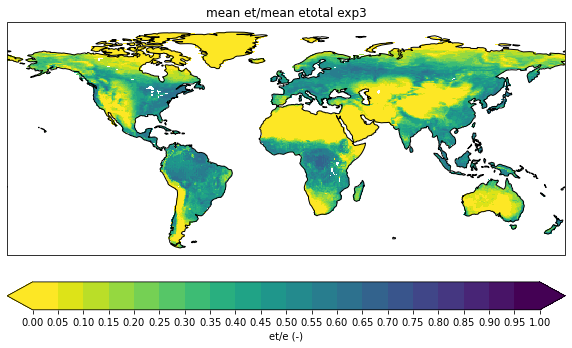

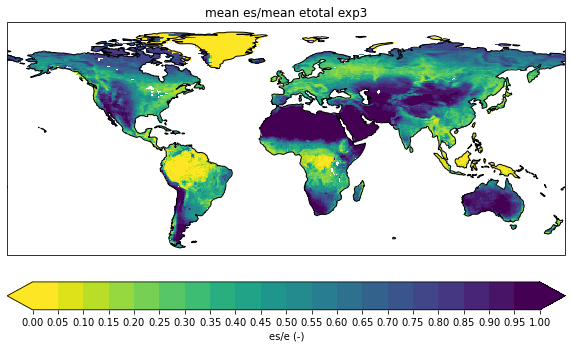

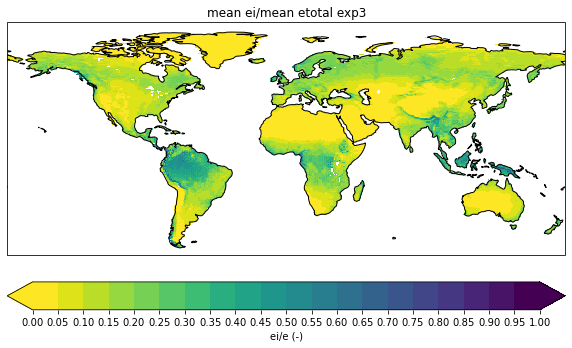

In [10]:
start_year='1999'
end_year='2018'

exp_name='exp1'
plot_e(exp_name,start_year,end_year)

exp_name='exp3'
plot_e(exp_name,start_year,end_year)

In [11]:
# def plot_ediff_tables(exp_name1, exp_name2,start_year,end_year):
def plot_means(exp_name1):
    f_mod = f'{fol}/htessel_output/{exp_name1}'
    mod = xr.open_dataset(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    c_et = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','TVEG')
    c_es = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','ESOIL')
    c_ei = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','evatc')
    c_e = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','E')
    c_p = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','TP')
    c_q = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','RO')

    c_et.coord('latitude').guess_bounds()
    c_et.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(c_et)

    c_etm = c_et.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_esm = c_es.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_eim = c_ei.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_e = c_e.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_p = c_p.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_q = c_q.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)

    etm = xr.DataArray.from_iris(c_etm) * -1000
    esm = xr.DataArray.from_iris(c_esm) * -1000
    eim = xr.DataArray.from_iris(c_eim) * -1000
    em = xr.DataArray.from_iris(c_e) * -1000
    pm = xr.DataArray.from_iris(c_p) * 1000
    qm = xr.DataArray.from_iris(c_q) * 1000

    fig=plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.plot(etm.time,etm, label='et')
    ax.plot(esm.time,esm, label='es')
    ax.plot(eim.time,eim, label='ei')
    ax.plot(em.time,em, label='e total')
    ax.set_ylabel('e (mm/day)')
    ax.set_ylim(0,2)
    ax.set_title(f'global mean evaporation {exp_name1}')
    ax.legend()
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/timeseries_e_{exp_name1}.jpg',bbox_inches='tight')

    fig=plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.plot(em.time,em, label='e')
    ax.plot(qm.time,qm, label='q')
    ax.plot(pm.time,pm, label='p')
    ax.set_ylabel('flux (mm/day)')
    ax.set_ylim(0,3)
    ax.set_title(f'global mean p q and e {exp_name1}')
    ax.legend()
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/timeseries_pqe_{exp_name1}.jpg',bbox_inches='tight')

    # print(f'global mean Etotal {exp_name1}: {em2.mean()}')

In [12]:
def plot_means2(exp_name1,exp_name2):
    f_mod = f'{fol}/htessel_output/{exp_name1}'
    mod = xr.open_dataset(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    c_et = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','TVEG')
    c_es = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','ESOIL')
    c_ei = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','evatc')
    c_e = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','E')
    c_p = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','TP')
    c_q = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','RO')

    c_et.coord('latitude').guess_bounds()
    c_et.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(c_et)

    c_etm = c_et.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_esm = c_es.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_eim = c_ei.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_e = c_e.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_p = c_p.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_q = c_q.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)

    etm1 = xr.DataArray.from_iris(c_etm) * -1000
    esm1 = xr.DataArray.from_iris(c_esm) * -1000
    eim1 = xr.DataArray.from_iris(c_eim) * -1000
    em1= xr.DataArray.from_iris(c_e) * -1000
    pm1 = xr.DataArray.from_iris(c_p) * 1000
    qm1 = xr.DataArray.from_iris(c_q) * 1000
    
    f_mod = f'{fol}/htessel_output/{exp_name2}'
    mod = xr.open_dataset(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
    c_et = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','TVEG')
    c_es = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','ESOIL')
    c_ei = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','evatc')
    c_e = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','E')
    c_p = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','TP')
    c_q = iris.load_cube(f'{f_mod}/monthly/o_wat_{start_year}_{end_year}_monthly.nc','RO')

    c_et.coord('latitude').guess_bounds()
    c_et.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(c_et)

    c_etm = c_et.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_esm = c_es.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_eim = c_ei.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_e = c_e.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_p = c_p.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
    c_q = c_q.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)

    etm2 = xr.DataArray.from_iris(c_etm) * -1000
    esm2 = xr.DataArray.from_iris(c_esm) * -1000
    eim2 = xr.DataArray.from_iris(c_eim) * -1000
    em2 = xr.DataArray.from_iris(c_e) * -1000
    pm2 = xr.DataArray.from_iris(c_p) * 1000
    qm2 = xr.DataArray.from_iris(c_q) * 1000

    fig=plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.plot(etm1.time,etm1,'g', label=f'et {exp_name1}')
    ax.plot(esm1.time,esm1,'r', label=f'es {exp_name1}')
    ax.plot(eim1.time,eim1,'b', label=f'ei {exp_name1}')
    ax.plot(em1.time,em1,'k', label=f'e total {exp_name1}')
    ax.plot(etm2.time,etm2,'g--', label=f'et {exp_name2}')
    ax.plot(esm2.time,esm2,'r--', label=f'es {exp_name2}')
    ax.plot(eim2.time,eim2,'b--', label=f'ei {exp_name2}')
    ax.plot(em2.time,em2,'k--', label=f'e total {exp_name2}')
    ax.set_ylabel('e (mm/day)')
    ax.set_ylim(0,2)
    ax.set_title(f'global mean evaporation {exp_name1} and {exp_name2}')
    ax.legend()
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/timeseries_e_{exp_name1}_{exp_name2}.jpg',bbox_inches='tight')
    
    fig=plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.plot(etm1.time,etm1,'g', label=f'et {exp_name1}')
    ax.plot(esm1.time,esm1,'r', label=f'es {exp_name1}')
    ax.plot(etm2.time,etm2,'g--', label=f'et {exp_name2}')
    ax.plot(esm2.time,esm2,'r--', label=f'es {exp_name2}')
    ax.set_ylabel('e (mm/day)')
    ax.set_ylim(0,1.2)
    ax.set_title(f'global mean evaporation {exp_name1} and {exp_name2}')
    ax.legend()
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/timeseries_et_es_{exp_name1}_{exp_name2}.jpg',bbox_inches='tight')

    fig=plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.plot(em1.time,em1,'g', label=f'e {exp_name1}')
    ax.plot(qm1.time,qm1,'r', label=f'q {exp_name1}')
    ax.plot(pm1.time,pm1,'b', label=f'p {exp_name1}')
    ax.plot(em2.time,em2,'g--', label=f'e {exp_name2}')
    ax.plot(qm2.time,qm2,'r--', label=f'q {exp_name2}')
    ax.plot(pm2.time,pm2,'b--', label=f'p {exp_name2}')
    ax.set_ylabel('flux (mm/day)')
    ax.set_ylim(0,3)
    ax.set_title(f'global mean p q and e {exp_name1} and {exp_name2}')
    ax.legend()
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/evaporation_fig/timeseries_epq_{exp_name1}_{exp_name2}.jpg',bbox_inches='tight')
    
    # print(em2)
    # print(f'global mean Etotal {exp_name1}: {em2.mean()}')


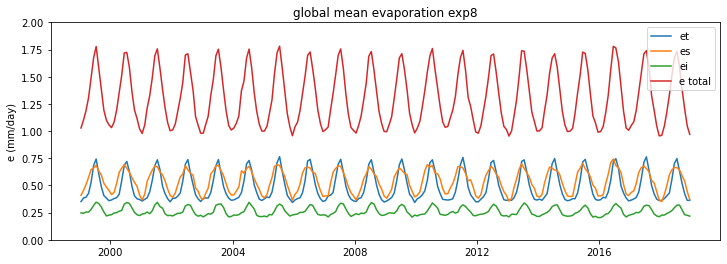

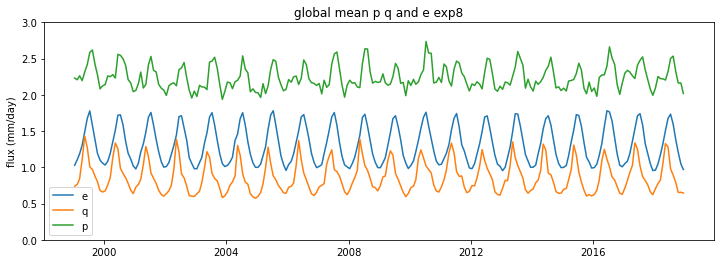

In [13]:
# plot_means('exp1')
# plot_means('exp3')
plot_means('exp8')

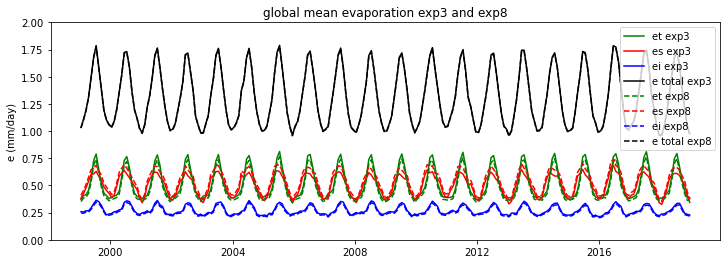

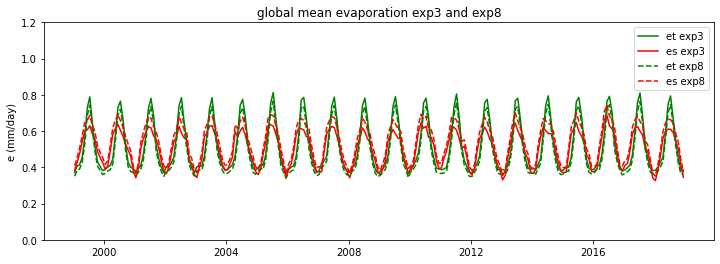

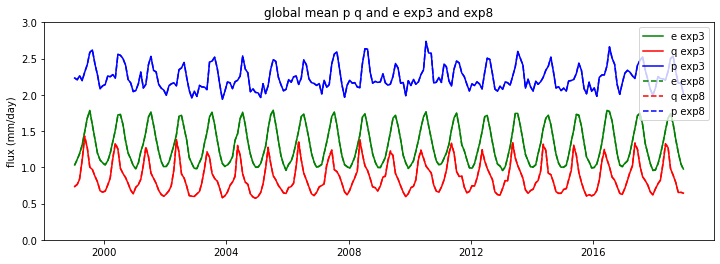

In [14]:
# plot_means2('exp1','exp3')
plot_means2('exp3','exp8')